In [1]:
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
from scipy.signal import correlate
import time
from codecarbon import EmissionsTracker

### Signal simple

Données du signal_simple:

In [2]:
""" Valeurs"""

l,step = np.linspace(600,1400,1000, retstep = True)
    
l0 = 656.3
z = np.random.uniform(0.0,1.0)
obs = z*l0 + l0
    
dev = 0.01*obs
    
""" DONNEES """

ysig = 20*stats.norm.pdf(l,obs,dev)
bruit = np.random.normal(0,1,1000)
data = ysig + bruit

""" MODELS: Du signal et du bruit """

lmod,step = np.linspace(0,60*step,60, retstep = True)
ymodel = stats.norm.pdf(lmod,(step*60/2),8)

bruitmod = np.random.normal(0,1,1000)
    

Traitement du signal simple par notre code initial:

In [3]:
start = time.time()  


def cross(filtr,data):
    """
    Fait le produit scalaire morceau par morceau du temps
    entre le filtre et le signal mesuré (signal + bruit)

    Args:
        filtr (array): filtre
        data (array): signal + bruit

    Returns:
        array : signal filtré
    """
    sizemod = np.size(filtr)
    sizesig = np.size(data)
        
    prod = []
    
    for i in range(sizesig-sizemod):
        p = np.dot(filtr,data[i:(i+sizemod)])
        prod.append(p)
    return prod
    

# Corrélations croisées modèle/données
prodat = np.zeros(940)
for i in range(1000):
    prodat += cross(ymodel,data)
prodat /= 1000
# Corrélations croisées modèle/bruit
prodbruit = cross(ymodel,bruitmod)
    
devbr = np.std(prodbruit)
SNR = prodat/devbr


end = time.time()
t = end - start
print(t, "s")

1.1304295063018799 s


Traitement du signal simple par la fonction correlate. Comme le signal est tronqué, il faut utilisé le mode valid pour ne pas avoir un décalage.

In [4]:
start_2 = time.time()

prodat_2 = correlate(data, ymodel, mode='valid')
    
# Corrélations croisées modèle/bruit
prodbruit_2 = correlate(bruitmod, ymodel, mode='valid')
    
devbr_2 = np.std(prodbruit_2)
SNR_2 = prodat_2/devbr_2

end_2 = time.time()
t_2 = end_2 - start_2
print(t_2, "s")

0.002485990524291992 s


La fonction correlate est environ 1000 fois plus rapide que notre filtre.


Pour notre code, le signal est à la position temporelle: 540         
Pour correlate : 540

 Notre code prends 1.1304295063018799 s en run et la fonction correlate prends 0.002485990524291992 s.


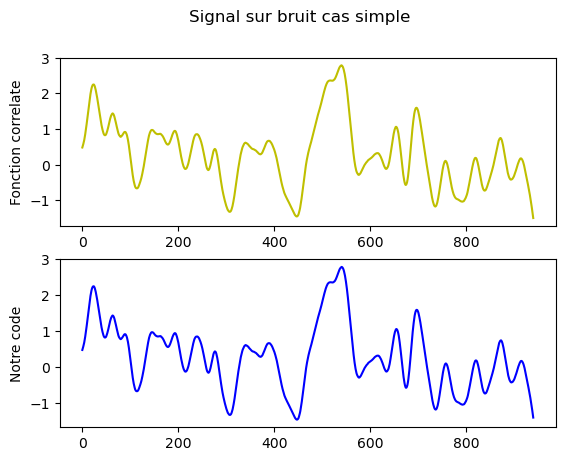

In [5]:
print("\nPour notre code, le signal est à la position temporelle:",np.argmax(np.abs(SNR)), "\
        \nPour correlate :", np.argmax(np.abs(SNR_2)))
print("\n Notre code prends", t, "s en run et la fonction correlate prends", t_2, "s.")
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Signal sur bruit cas simple')

ax1.plot(SNR_2, 'y')
ax1.set_ylabel('Fonction correlate')

ax2.plot(SNR, 'b')
ax2.set_ylabel('Notre code')

plt.show()

Pour un signal simple, la fonction correlate donne les mêmes résultats que notre filtre en environ 1000 fois moins de temps.

### Signal complexe

Annalyse signal complexe:

Données initiales nécessaires :

In [6]:
tps = np.linspace(0, 10, 1000, retstep = True)

temps = tps[0]
pas = tps[1]

temps1 = temps[0:100]

pos = np.random.randint(1000-100)

Toutes les fonctions nécessaires regroupées :

In [7]:
def sinusoidal(temps, amplitude_init, pulsation_init):
    """
    Génére un signal dont l'amplitude et la frequence augmentent en
    fonction du temps de manière linéaire

    Args:
        temps (array): temps
        amplitude_init (float): Amplitude initiale du signal
        pulsation_init (float): Fréquence initiale du signal
    Returs:
        array : signal sinusoïdal
    """
    amplitude = amplitude_init*temps
    pulsation = pulsation_init*temps
    
    signal = amplitude*np.sin(pulsation*temps)
    return signal

def psd(frequence, gamma):
    """
    Calcule la densité spectrale de puissance d'un bruit coloré

    Args:
        frequence (array): frange frequences positives à partir desquelles générer un bruit coloré
        gamma (float): indice loi de puissance

    Returns:
        array : loi de puissance
    """
    p = ((frequence[frequence>0])/10)**(gamma) + 1
    return p

def miroir(densite):
    """
    Génére la partie miroir d'une fonction et la rajoute à cette fonction.
    Ajoute aussi le 0.

    Args:
        densite (array): fontion à laquelle on veut ajouter sa partie miroir.

    Returns:
        array : fonction avec partie miroir et 0
    """
    densite = np.insert(densite, 0,  0)
    densite = np.concatenate((densite, np.flip(densite)))
    return densite

def bruit(densite):
    """
    Crée du bruit coloré à partir de sa densité spectrale de puissance.

    Args:
        densite (array): densité spectrale de puissance du bruit coloré dans l'espace de Fourier.

    Returns:
        array : le bruit coloré dans l'espace réel
    """
    bruit_blanc = np.random.normal(0,1,1000)
    fourier_blanc = np.fft.fft(bruit_blanc)
    
    fourier_color = fourier_blanc*np.sqrt(densite)
    bruit_color = np.real(np.fft.ifft(fourier_color))
    
    return bruit_color

def signalsurbruit(densite, signal, position):
    """
    Introduit un signal dans du bruit coloré

    Args:
        densite (array): densité spectrale de puissance du bruit coloré
        signal (array): signal
        position (int): position où mettre la signal dans le bruit

    Returns:
        array: data : signal + bruit
    """
    bruit_color = bruit(densite)
    bruit_color[position:position+np.size(signal)] += signal
    
    return bruit_color

def covariance(densite, temps):
    """
    Calcule l'inverse de la matrice de covariance de 1000 réalisations du bruit en 1 s

    Args:
        densite (array): densité spectrale de puissance du bruit coloré
        temps (array): plage de temps

    Returns:
        array : Matrice de covariance (Cn) et son inverse (cov)
    """
    Cn = np.zeros((100,100))
    for i in range(1000):
        bruit_color = bruit(densite)
        Cn += np.dot(np.transpose(bruit_color[None, 0:100]), bruit_color[None, 0:100])
    Cn /= np.size(temps)
    cov = np.linalg.inv(Cn)
    return cov, Cn

def cross(filtr,data):
    """
    Fait le produit scalaire morceau par morceau du temps
    entre le filtre et le signal mesuré (signal + bruit)

    Args:
        filtr (array): filtre
        data (array): signal + bruit

    Returns:
        array : signal filtré
    """
    sizemod = np.size(filtr)
    sizesig = np.size(data)
        
    prod = []
    
    for i in range(sizesig-sizemod):
        p = np.dot(filtr,data[i:(i+sizemod)])
        prod.append(p)
    return prod
    
def bruitfiltre(densite,filtre):
    """
    Filtre 1000 réalisations de bruit

    Args:
        densite (array): densité spectrale de puissance
        filtre (array): filtre

    Returns:
        array : (bruit_filtre) bruit filtré en moyenne
        float : (devbr) écart type bruit filtré (1000 réalisations)
    """
    bruit_filtre = np.zeros(900)
    devbr = 0
    for i in range(1000):
        bruit_color = bruit(densite)
        prodbruit = cross(filtre, bruit_color)
        bruit_filtre += prodbruit
        dev = np.std(prodbruit)
        devbr+= dev
    bruit_filtre = bruit_filtre/1000
    devbr = devbr/1000
    return bruit_filtre, devbr

def bruitfiltre_correlate(densite,filtre):
    """
    Filtre 1000 réalisations de bruit avec la fonction correlate

    Args:
        densite (array): densité spectrale de puissance
        filtre (array): filtre

    Returns:
        array : (bruit_filtre) bruit filtré en moyenne
        float : (devbr) écart type bruit filtré (1000 réalisations)
    """
    bruit_filtre = np.zeros(901)
    devbr = 0
    n = 1000
    for i in range(n):
        bruit_color = bruit(densite)
        prodbruit = correlate(bruit_color, filtre, mode='valid')
        bruit_filtre += prodbruit
        dev = np.std(prodbruit)
        devbr+=dev
    bruit_filtre = bruit_filtre/n
    devbr = devbr/1000
    return bruit_filtre, devbr

Définition du signal avec le bruit et du modèle du signal et du bruit qu'on va utiliser pour le filtre :

In [8]:
# Signal
amp_init = 2
puls_init = 30 # en rad/s

signal = sinusoidal(temps1, amp_init, puls_init)

#Bruit
gamma = -1.55
frequence = np.fft.fftfreq(np.size(temps), pas)
bruit_color = psd(frequence, gamma)
bruit_color = miroir(bruit_color)

#Bruit + signal (data)
signal_bruit = signalsurbruit(bruit_color, signal, pos)

# Model signal
amp_init_model = 1
signal_model = sinusoidal(temps1, amp_init_model, puls_init)

# Inverse covariance
cov, Cn = covariance(bruit_color, temps1)

# Filtre
filtre = np.dot(cov, signal_model)

Correlations croisés et calcul de SNR : 

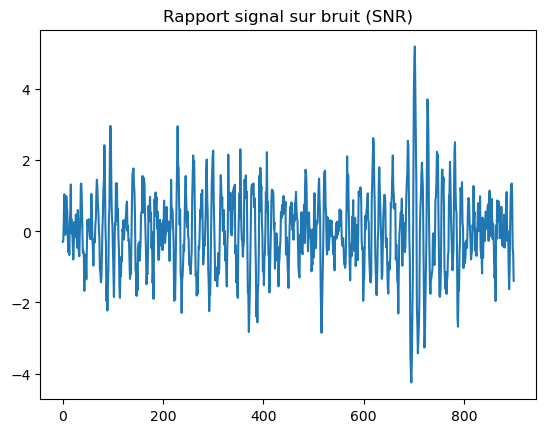


Temps mis par notre code pour le signal complexe: 1.4293644428253174 s


In [9]:
# Signal
start = time.time() 

prodat = cross(filtre, signal_bruit)

#Bruit
bruit_filtre, devbr = bruitfiltre(bruit_color,filtre)

SNR_3 = prodat/devbr

plt.plot(SNR_3)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

end = time.time()
t = end - start
print("\nTemps mis par notre code pour le signal complexe:", t, "s")

Traitement avec la fonction correlate:

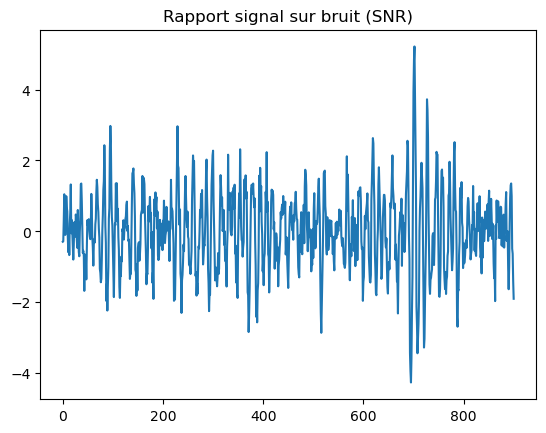


Temps mis par la fonction correlate pour le signal complexe: 0.2501637935638428 s


In [10]:
start_2 = time.time()

# Corrélations croisés modèle/signal

prodat_2 = correlate(signal_bruit, filtre, mode='valid')

# Corrélations croisées modèle/bruit

prod_bruit2, devbr_2 = bruitfiltre_correlate(bruit_color,filtre)


# SNR

SNR_4 = prodat_2/devbr_2

plt.plot(SNR_4)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

end_2 = time.time()
t_2 = end_2 - start_2
print("\nTemps mis par la fonction correlate pour le signal complexe:", t_2, "s")

Dans ce cas là, la fonction correlate est 10 fois plus rapide que notre filtrage.


Pour notre code, le signal est à la position temporelle: 702         
Pour correlate : 702

Notre code prends 1.4293644428253174 s en run et la fonction correlate prends 0.2501637935638428 s.


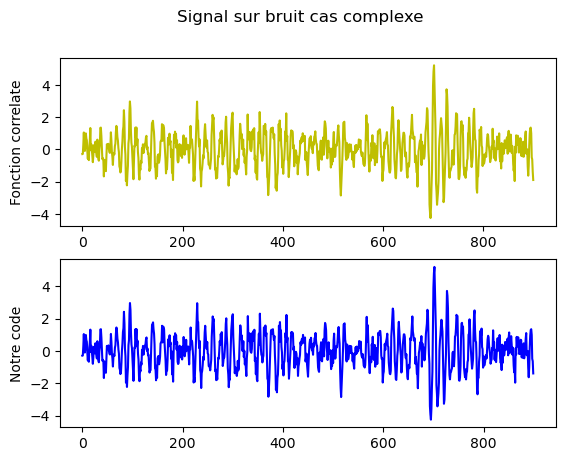

In [11]:
print("\nPour notre code, le signal est à la position temporelle:",np.argmax(np.abs(SNR_3)), "\
        \nPour correlate :", np.argmax(np.abs(SNR_4)))
print("\nNotre code prends", t, "s en run et la fonction correlate prends", t_2, "s.")

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Signal sur bruit cas complexe')

ax1.plot(SNR_4, 'y')
ax1.set_ylabel('Fonction correlate')

ax2.plot(SNR_3, 'b')
ax2.set_ylabel('Notre code')

plt.show()

Notre filtre donne un signal sur bruit en 10 fois plus de temps.

La partie code carbon, vous pouvez la trouver sur le script comparaison.py. Le fichier.csv vous pouvez le trouver dans le dossier aussi sous le nom emissions.csv. On a émis environ 3.47 e-7 kg de CO2